In [1]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.regression.linear_model as lm

pd.get_option("display.max_columns", None)

20

# Final Project: Question 2

- Which factors affect the monetary rewards of appealing? 
- What influences how much money one might gain from a successful appeal?

Utilize multivariate OLS. Our goal is to understand whether there is bias or unfairness in the tax system.

In [2]:
df = pd.read_csv('project2data.csv')

print('Dataset Description:')
print(' Original Format: comma-separated values file')
print(' Observations: Random sample of property tax appeals within Cook County')
print(' Number of observations (rows):', df.shape[0])
print(' Number of features (columns):', df.shape[1])
print(' Feature names:  ',
      ', '.join([(element + "\n\t\t") if (index % 4 ==0) else element \
                for index, element in enumerate(sorted(df.columns), start=1)]))
print(" Dependent variable: appeal")
print("   *appeal = dollar amount deducted from assessed value after property owner appealed. If NA there was no appeal.")
print(" Source: Cook County Assessor's Office")
print(' Contact: datascience@cookcountyassessor.com')

Dataset Description:
 Original Format: comma-separated values file
 Observations: Random sample of property tax appeals within Cook County
 Number of observations (rows): 19036
 Number of features (columns): 26
 Feature names:   appeal, asian, av1, avg_school_score
		, beds, black, college, condo
		, elem_score, high_school_score, hispanic, homeowner
		, medhinc, pcity, pdir, pin14
		, poverty, pstreet, squarefoot, taxes
		, tcity, tri, value, walkfac
		, walkscore, white
 Dependent variable: appeal
   *appeal = dollar amount deducted from assessed value after property owner appealed. If NA there was no appeal.
 Source: Cook County Assessor's Office
 Contact: datascience@cookcountyassessor.com


# Data Quality - Review Preprocessing

Take a high-level review of the data and remap when necessary.

In [3]:
# Review continuous features
df.describe()

,pin14,av1,value,taxes,homeowner,white,black,hispanic,asian,medhinc,poverty,college,squarefoot,beds,walkscore,elem_score,high_school_score,avg_school_score,appeal
count,1.903600e+04,1.899100e+04,1.903600e+04,19036.000000,19036.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,18914.000000,13915.000000,13915.000000,19036.000000,19036.000000,19036.000000,19036.000000,9.018000e+03
mean,1.806325e+13,3.036896e+04,3.564597e+05,4972.586580,0.426087,0.625657,0.205279,0.186143,0.139870,67020.153960,0.135024,0.318044,1908.737478,3.648653,69.779838,5.453719,5.394883,5.644411,5.394141e+03
std,5.788279e+12,2.961622e+04,3.641909e+05,4233.282368,0.494520,0.274867,0.296543,0.214204,0.118632,26266.301109,0.099465,0.212173,1167.077974,1.701771,23.504392,2.406259,2.865633,2.223499,2.029286e+04
min,9.253050e+12,-1.045572e+06,5.000000e+03,0.000000,0.000000,0.001088,0.000789,0.001889,0.000000,9550.000000,0.003604,0.004178,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000e+00
25%,1.418130e+13,1.534750e+04,1.750000e+05,2479.315050,0.000000,0.499139,0.020925,0.053135,0.053844,47972.000000,0.065292,0.134969,1151.000000,3.000000,55.000000,3.000000,3.000000,4.000000,0.000000e+00
50%,1.704110e+13,2.367500e+04,2.660000e+05,3940.760000,0.000000,0.703167,0.051095,0.091340,0.099713,63529.000000,0.112022,0.265332,1567.000000,3.000000,75.000000,6.000000,5.000000,6.000000,1.177500e+03
75%,2.016100e+13,3.680350e+04,4.130000e+05,6088.760125,1.000000,0.851731,0.261715,0.217768,0.194202,84167.000000,0.170868,0.505770,2297.000000,4.000000,89.000000,7.000000,8.000000,7.000000,4.375000e+03
max,3.331210e+13,7.639090e+05,1.500000e+07,133258.690000,1.000000,0.970822,0.993390,0.979010,0.896609,192143.000000,0.776376,0.766168,27270.000000,24.000000,100.000000,10.000000,10.000000,10.000000,1.164486e+06


In [4]:
# Drop duplicate rows
print("Total df row count: ",len(df))
print("Row count after dropping duplicate rows: ", len(df.drop_duplicates()))
df = df.drop_duplicates().reset_index(drop=True) 

Total df row count:  19036
Row count after dropping duplicate rows:  18904


In [5]:
# Data Quality Review for each feature individually and remap when necessary
for feature in sorted(list(df.columns)):
    # Feature Summary section
    print(feature,':  data type:',str(df.dtypes[feature]))
    print('       unique values:',len(df[feature].unique()))
    if len(df[feature].unique()) < 20 and not isinstance(df[feature], str):
        print("    Original unique values for review:", str(df[feature].unique()))
    
    if feature == 'walkfac':
        Walkfac_dict = {'Car-Dependent': '1',
                        'Somewhat Walkable': '2',
                        'Very Walkable': '3',
                        "Walker's Paradise": '4'
                            }
        df[feature] = df[feature].map(Walkfac_dict)
        print("    New unique values for review:", str(sorted(df[feature].unique())))
    if feature == 'condo':
        Walkfac_dict = {'Non-condo': 0,
                        'Condominium': 1
                            }
        df[feature] = df[feature].map(Walkfac_dict)
        print("    New unique values for review:", str(sorted(df[feature].unique())))
    if feature == 'tri':
        # Convert data type to category
        df[feature] = df[feature].astype('category')
        print("New data type:",str(df.dtypes[feature]) )    
    if feature == 'pin14':
        # Convert data type to category
        df[feature] = df[feature].astype('str')
        print("New data type:",str(df.dtypes[feature]))

appeal :  data type: float64
       unique values: 4302
asian :  data type: float64
       unique values: 1108
av1 :  data type: float64
       unique values: 15796
avg_school_score :  data type: int64
       unique values: 10
    Original unique values for review: [ 4  9  2  6  8  3  7  5  1 10]
beds :  data type: float64
       unique values: 21
black :  data type: float64
       unique values: 1110
college :  data type: float64
       unique values: 1109
condo :  data type: object
       unique values: 2
    Original unique values for review: ['Non-condo' 'Condominium']
    New unique values for review: [0, 1]
elem_score :  data type: int64
       unique values: 10
    Original unique values for review: [ 1 10  5  8  2  7  4  9  6  3]
high_school_score :  data type: int64
       unique values: 10
    Original unique values for review: [ 6  8  2 10  1  5  4  9  7  3]
hispanic :  data type: float64
       unique values: 1110
homeowner :  data type: int64
       unique values: 2
    Or

In [6]:
# Break pin14 feature into subcomponents and drop
# Per docs:
# All PINs are 14 digits: 2 digits for area + 2 digits for sub area + 2 digits for block + 2 digits for parcel + 4 digits for the multicode
# NOTE: Docs do not account for meaning of full 14 digits (above adds up to 12; unclear of any meaning for last 2 digits)
df['area']      = df.pin14.str[0:2]
df['subarea']   = df.pin14.str[2:4]
df['block']     = df.pin14.str[4:6]
df['parcel']    = df.pin14.str[6:8]
df['multicode'] = df.pin14.str[8:12]
df = df.drop(columns='pin14')

# Review feature unique values
for feature in ['area','subarea','block','parcel','multicode']:
    # Feature Summary section
    print(feature, '  unique values:',len(df[feature].unique()))
    if len(df[feature].unique()) < 20 and not isinstance(df[feature], str):
        print("    Original unique values for review:", str(df[feature].unique()))

# Drop less useful features based on low cardinality
df = df.drop(columns='parcel')
df = df.drop(columns='multicode')

area   unique values: 26
subarea   unique values: 42
block   unique values: 41
parcel   unique values: 1
    Original unique values for review: ['00']
multicode   unique values: 1
    Original unique values for review: ['0000']


In [7]:
# Encode categorical features; Always drop one column to prevent multicollinearity issues
df = pd.get_dummies(df, columns=['walkfac'], prefix='walkfac', prefix_sep='_', drop_first=True)
df = pd.get_dummies(df, columns=['tri'], prefix='tri', prefix_sep='_', drop_first=True)

In [8]:
# create tax rate (Jeff's code)
df['tax_rate'] = df['taxes'] / df['value'] * 100
df = df.drop(columns='taxes')

## Data Quality - Missingness

Assess and handle missing data

In [9]:
# Review missingness
print("Feature_________________Missing Value Count")
print(df.isna().sum())
print("\ndf row count:",len(df))

Feature_________________Missing Value Count
pdir                                  5439
pstreet                                  1
pcity                                    1
tcity                                    0
condo                                    0
av1                                     45
value                                    0
homeowner                                0
white                                  122
black                                  122
hispanic                               122
asian                                  122
medhinc                                122
poverty                                122
college                                122
squarefoot                            5118
beds                                  5118
walkscore                                0
elem_score                               0
high_school_score                        0
avg_school_score                         0
appeal                                9982
area      

In [10]:
# We only need those who appealed for this question (>=0); drop those who did not appeal (NaN)
df = df[df.appeal.notnull()]
print("Row count after dropping null appeal observations:",len(df))

Row count after dropping null appeal observations: 8922


In [11]:
# Drop features based on missingness (>10%) (not candidate for imputation)
## squarefoot and beds are each missing 2567 observations; missingness has 1-1 correlation
df = df.drop(columns='pdir')       # Missing 2353/8922 
df = df.drop(columns='squarefoot') # Missing 2567/8922 
df = df.drop(columns='beds')       # Missing 2567/8922 

In [12]:
# Manual review finds missingness is 1-1 for white, black, hispanic, asian, medhinc, poverty, and college features.
## Missing 91/8922 observations (~1%); opted to drop these.
df = df[df.college.notnull()]

In [13]:
# Review missingness of data; final row count 8831
print("Feature_________________Missing Value Count")
print(df.isna().sum())
print("\ndf row count:",len(df))

Feature_________________Missing Value Count
pstreet                               0
pcity                                 0
tcity                                 0
condo                                 0
av1                                   0
value                                 0
homeowner                             0
white                                 0
black                                 0
hispanic                              0
asian                                 0
medhinc                               0
poverty                               0
college                               0
walkscore                             0
elem_score                            0
high_school_score                     0
avg_school_score                      0
appeal                                0
area                                  0
subarea                               0
block                                 0
walkfac_2                             0
walkfac_3                           

# Additional Preprocessing

In [14]:
# Create new feature log_appeal
# ## Exclude where appeal = 0 because these are unsuccessful appeals (no monetary reward).
df = df[(df['appeal']>0)]
df['log_appeal'] = np.log(df['appeal'])

# Create new variables for right skewed distributions on certain feature variables 
df['log_value'] = np.log(df['value'])
df['log_medhinc'] = np.log(df['medhinc'])


# Convert all continuous features to float32 (aligns w/ regression modeling package requirements in next section)
cols = ['condo', 'av1', 'log_value', 'homeowner',
       'white', 'black', 'hispanic', 'asian', 'log_medhinc', 'poverty', 'college',
       'walkscore', 'elem_score', 'high_school_score', 'avg_school_score',
       'area', 'subarea', 'block', 'walkfac_2', 'walkfac_3', 'walkfac_4',
       'tri_Northwest Suburban Cook County',
       'tri_Southwest Suburban Cook County', 'tax_rate', 'log_appeal'
       ]
for col in cols:
    df[col] = df[col].astype('float32')

# Removes spaces in col name
df.rename(columns={'tri_Southwest Suburban Cook County': 'tri_SouthwestSuburbanCookCounty', 'tri_Northwest Suburban Cook County': 'tri_NorthwestSuburbanCookCounty'}, inplace=True)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5474 entries, 2 to 18903
Data columns (total 31 columns):
pstreet                            5474 non-null object
pcity                              5474 non-null object
tcity                              5474 non-null object
condo                              5474 non-null float32
av1                                5474 non-null float32
value                              5474 non-null int64
homeowner                          5474 non-null float32
white                              5474 non-null float32
black                              5474 non-null float32
hispanic                           5474 non-null float32
asian                              5474 non-null float32
medhinc                            5474 non-null float64
poverty                            5474 non-null float32
college                            5474 non-null float32
walkscore                          5474 non-null float32
elem_score                         5474 no

In [16]:
# Scale continuous features (normalization); Reduces model weighting on value size
# cols_to_norm = [
#   'av1', 'value', 'white', 'black', 'hispanic', 'asian',
#   'medhinc', 'poverty', 'college', 'walkscore', 'elem_score',
#   'high_school_score', 'avg_school_score', 'tax_rate'
#   ,'area', 'subarea', 'block'
#   ]
# df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [17]:
# Move log_appeal to first position
first_column = df.pop('log_appeal')
df.insert(0, 'log_appeal', first_column)

# Remove unwieldy string columns
df = df.drop(columns=['pstreet', 'pcity', 'tcity']) 

# Remove columns converted to natural log 
df = df.drop(columns=['value', 'medhinc']) 

# Remove poorly defined column per Jeff's conversation w/ TA
df = df.drop(columns='av1') 

df.head()

,log_appeal,condo,homeowner,white,black,hispanic,asian,poverty,college,walkscore,...,subarea,block,walkfac_2,walkfac_3,walkfac_4,tri_NorthwestSuburbanCookCounty,tri_SouthwestSuburbanCookCounty,tax_rate,log_value,log_medhinc
2,8.342602,0.0,0.0,0.507349,0.214669,0.096806,0.244488,0.263047,0.344634,82.0,...,8.0,42.0,0.0,1.0,0.0,0.0,0.0,0.853575,14.126097,10.402140
3,10.574108,0.0,0.0,0.884098,0.015355,0.087505,0.063736,0.011499,0.517047,76.0,...,19.0,13.0,0.0,1.0,0.0,0.0,0.0,0.294599,13.903064,11.435925
7,9.189424,0.0,1.0,0.884189,0.048890,0.040915,0.048544,0.079787,0.696402,94.0,...,33.0,41.0,0.0,0.0,1.0,0.0,0.0,0.969112,13.715691,11.356599
8,10.228140,0.0,0.0,0.685848,0.083346,0.254261,0.178264,0.142172,0.462252,93.0,...,5.0,32.0,0.0,0.0,1.0,0.0,0.0,1.581288,13.394297,11.044888
9,8.032685,0.0,0.0,0.628940,0.039828,0.495415,0.264470,0.137874,0.278220,89.0,...,13.0,30.0,0.0,1.0,0.0,0.0,0.0,1.852642,12.779873,10.847258


## EDA

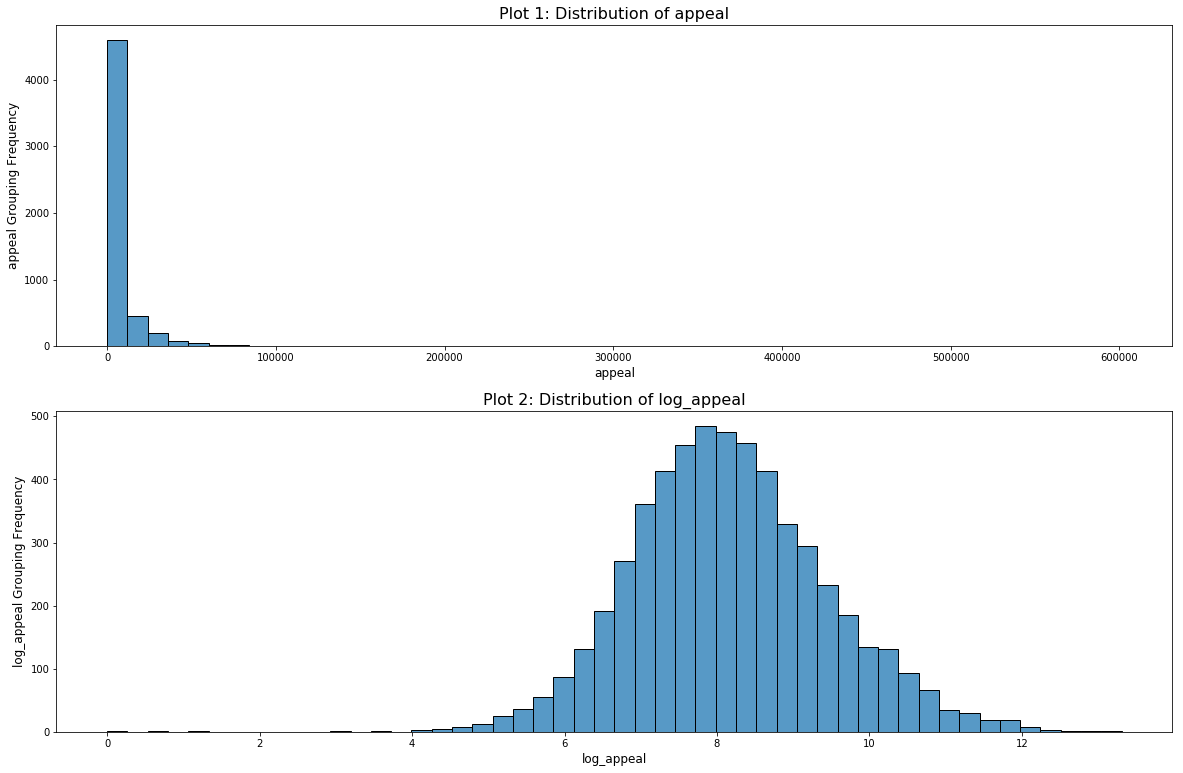

In [18]:
# Review dependent variable: appeal
plt.figure(figsize=(20,13))
plt.subplot(2, 1, 1)
ax1 = sns.histplot(df["appeal"], bins = 50, kde=False)
ax1.set_xlabel("appeal",fontsize=12)
ax1.set_ylabel("appeal Grouping Frequency",fontsize=12)
ax1.set_title('Plot 1: Distribution of appeal',fontsize=16)
plt.subplot(2, 1, 2)
ax1 = sns.histplot(df["log_appeal"], bins = 50, kde=False)
ax1.set_xlabel("log_appeal",fontsize=12)
ax1.set_ylabel("log_appeal Grouping Frequency",fontsize=12)
ax1.set_title('Plot 2: Distribution of log_appeal',fontsize=16)
plt.show()

# Drop appeal
df = df.drop(columns='appeal') 

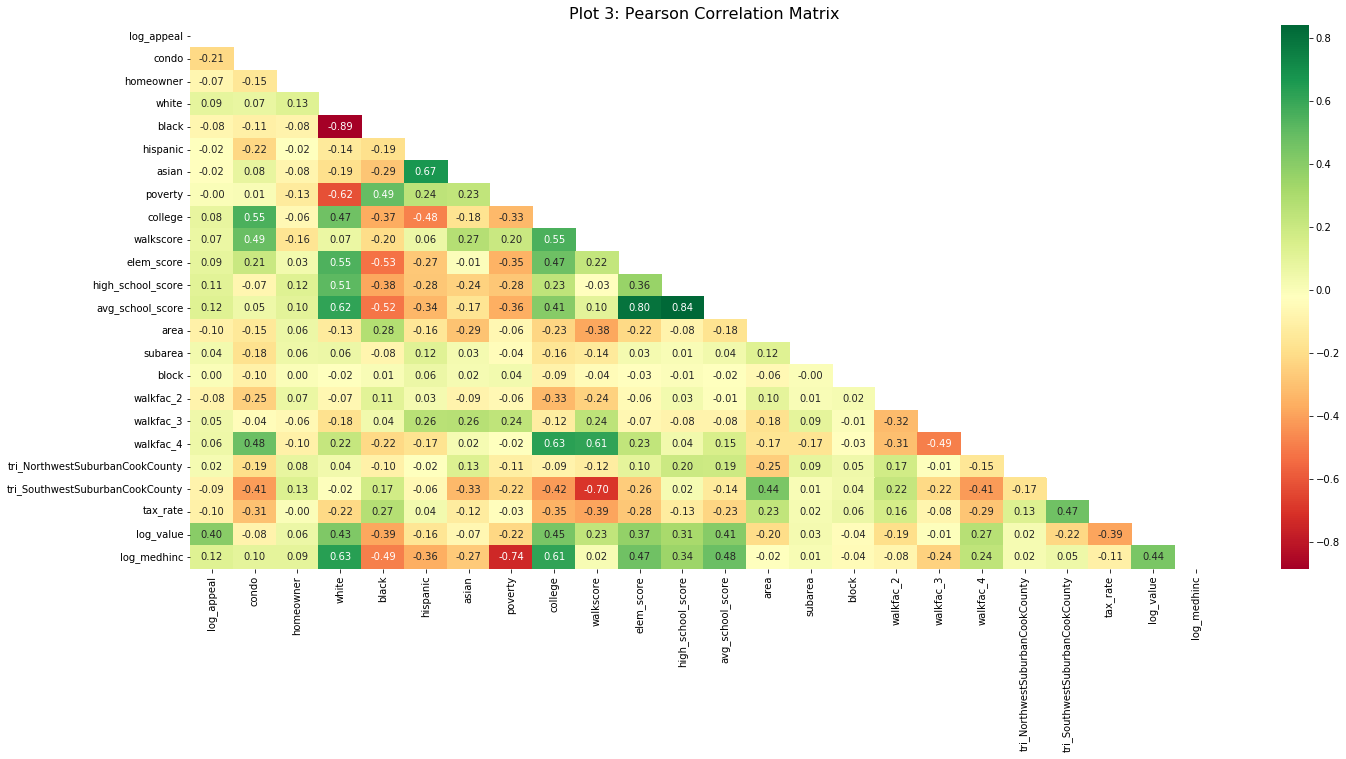

In [19]:
plt.figure(figsize=(23,10))
corr = df.corr(method='pearson')

# Retrieve lower left section matrix
matrix = np.triu(corr)

ax = sns.heatmap(corr, 
                 xticklabels=corr.columns.values,
                 yticklabels=corr.columns.values,
                 annot=True, 
                 fmt='.2f',
                 cmap='RdYlGn',
                 mask=matrix)
ax.set_title('Plot 3: Pearson Correlation Matrix',fontsize=16)
plt.show()

In [20]:
max(df['tax_rate'])

13.954771041870117

In [21]:
df.columns

Index(['log_appeal', 'condo', 'homeowner', 'white', 'black', 'hispanic',
       'asian', 'poverty', 'college', 'walkscore', 'elem_score',
       'high_school_score', 'avg_school_score', 'area', 'subarea', 'block',
       'walkfac_2', 'walkfac_3', 'walkfac_4',
       'tri_NorthwestSuburbanCookCounty', 'tri_SouthwestSuburbanCookCounty',
       'tax_rate', 'log_value', 'log_medhinc'],
      dtype='object')

#### Inital Data Exploration Analysis 

In this question, we are asked to examine which features may influence how much money one might gain from a successful appeal. In an initial review of the dataset sourced from the Cook County Assessor's Office, we find that there are 19,036 samples of property tax appeals in Cook County, but after dropping duplicate columns, creating dummy variables, and cleaning out missing data, we are left with 5,474 observations to run a regression on. Additionaly, since the question asks to understand the monetary influence of a successful appeal, we only consider properties that have a value for 'appeal' - the dependent variable which describes the change in property value after appeal. As seen in the visualization above (Plot 1), the linear values in the appeal are very right skewed, and in order to correct for this, we take the natural log of 'appeal' values, and we find that these values are much more normally distributed (Plot 2) and therefore better for creating a linear model. Therefore, the dependent variable in our regression models is **log_appeal**. 

We take the following to be potential features in our OLS regression model (definitions are sourced from the data dictionary with edits according to the above data cleaning processes): 

- **condo**: Binary variable describing if property is a condo (1) or not (0). 
- **log_value**: Natural log of property sale value when it actually sold. 
- **homeowner**: Binary variable describing if homeowner occupies property (1) or  not (0). 
- **white**: Percentage of associated property census tract inhabitants identified as White on US census. 
- **black**: Percentage of associated property census tract inhabitants identified as Black on US census.
- **hispanic**: Percentage of associated property census tract inhabitants identified as Hispanic on US census.
- **asian**: Percentage of associated property census tract inhabitants identified as Asian on US census.
- **log_medhinc**: Natural log of median household income of the property. 
- **poverty**: Percentage of property’s census tract inhabitants earning below the federal poverty rate. 
- **college**: Percentage of eligible adults in the property’s census tract with a 4 year college degree. 
- **walkscore**: Walkability score on a 100 point scale, using property distance to amenities. 
- **elem_score**: Greatschools rating for closest public neighborhood elementary school. 
- **high_school_score**: Greatschools rating for closest public neighborhood high school. 
- **avg_school_score**: Average of associated elementary and high school Greatschools ratings. 
- **area**: The first two digits of 'pin14' give an area (sequential township) number. 
- **subarea**: The following two digits of 'pin14' give a subarea (section) number. 
- **block**: The following three digits of 'pin14' give a block number. 
- **walkfac_2**: Dummy Variable for 'walkfac', 1 if 'Somewhat Walkable'. 
- **walkfac_3**: Dummy Variable for 'walkfac', 1 if 'Very Walkable'. 
- **walkfac_4**: Dummy Variable for 'walkfac', 1 if 'Walker's Paradise'. 
- **tri_NorthwestSuburbanCookCounty**: Dummy Variable for 'tri', 1 if Northwest Suburban Area. 
- **tri_SouthwestSuburbanCookCounty**: Dummy Variable for 'tri', 1 if Southwest Suburban Area. 
- **tax_rate**: Rate of amount of annual taxes paid by property owner (taxes / 100). 



In Plot 3, we take the Pearson Correlation Matrix of these data. Some interesting notes on this plot are as follows: 

- There is a strong negative correlation between White and Black population. In the context of this problem, it would be very intersting to see how (if) race, or the general racial distribution in an area, can affect the outcome of an appeal process and if different races tend to see successful appeals at different rates and values. 
- There is also a strong positive correlation between 'elem_score' and 'avg_school_score' and between 'high_school_score' and 'avg_school_score'. Though this is expected, it might be a potential source of multicollinearity in the regression models. 




## Analysis Section

### Bivariate Linear Regression Models

In [23]:
print('Dependent Variable: log_appeal')

features = []
rsquared = []
rsquared_adj = []
pvalues = []
SER=[]
columns = list(df.columns)
columns.remove('log_appeal')
n = len(df)

for col in columns:
    formula = "log_appeal ~ " + col
    model = smf.ols(formula=formula, data=df) 
    results = model.fit()
    features.append(col)
    rsquared.append(round(results.rsquared,4))
    rsquared_adj.append(round(results.rsquared_adj,4))
    pvalues.append(round(results.pvalues[0],6))
    SSR = df.apply(lambda x: (x[col]-(results.params[0]+results.params[1]*x['log_appeal']))**2, axis=1).sum()
    SER.append((SSR/(n-2))**(1/2))


# initialize dict of lists.
data = {'features': features,
        'rsquared': rsquared,
        'rsquared_adj': rsquared_adj,
        'p_value': pvalues,
        "SER": SER}
 
# Create dataframe & display for review
linear_model_stats = pd.DataFrame(data)
linear_model_stats.sort_values(by=['rsquared_adj'], ascending=False).head(50)


Dependent Variable: log_appeal


,features,rsquared,rsquared_adj,p_value,SER
21,log_value,0.1614,0.1613,0.902772,7.452174
0,condo,0.0453,0.0451,0.000000,3.319819
11,avg_school_score,0.0150,0.0148,0.000000,3.039148
22,log_medhinc,0.0144,0.0142,0.000000,4.150073
10,high_school_score,0.0114,0.0112,0.000000,3.680016
12,area,0.0097,0.0096,0.000000,11.703930
20,tax_rate,0.0096,0.0094,0.000000,5.845366
9,elem_score,0.0081,0.0079,0.000000,3.262743
2,white,0.0076,0.0074,0.000000,10.995616
19,tri_SouthwestSuburbanCookCounty,0.0074,0.0073,0.000000,5.948324


### Ordinary Least Squares Regression 

In [24]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
           
    Question: is the +1 in the formula becuase this method is trying to optimize the adjusted R-squared? 

    https://planspace.org/20150423-forward_selection_with_statsmodels/
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    predictions = model.predict(data)
    return model

In [25]:
model = forward_selected(df, 'log_appeal')

print(model.model.formula)

print("\n Adjusted R-squared:",model.rsquared_adj)
print(model.summary())

log_appeal ~ log_value + condo + homeowner + tri_SouthwestSuburbanCookCounty + poverty + log_medhinc + walkfac_2 + black + area + tri_NorthwestSuburbanCookCounty + tax_rate + walkfac_4 + walkfac_3 + walkscore + 1

 Adjusted R-squared: 0.22311583441774996
                            OLS Regression Results                            
Dep. Variable:             log_appeal   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     113.3
Date:                Sun, 27 Feb 2022   Prob (F-statistic):          3.73e-289
Time:                        15:55:00   Log-Likelihood:                -8429.3
No. Observations:                5474   AIC:                         1.689e+04
Df Residuals:                    5459   BIC:                         1.699e+04
Df Model:                          14                                         
Covariance Type:            nonrob

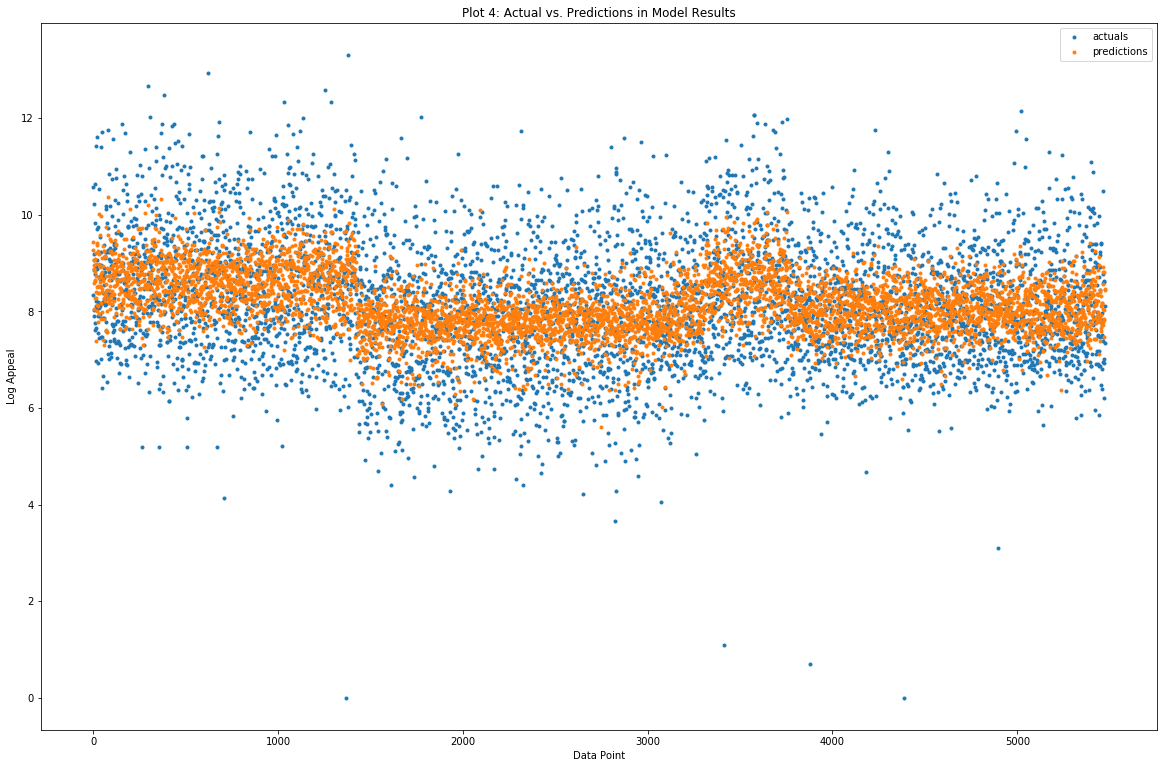

In [26]:
# Plot predictions vs. actuals 

predictions = model.predict(df)

plot_data = pd.DataFrame({
    "actuals": df['log_appeal'].to_list(), 
    "predictions": predictions.to_list()
})

plt.figure(figsize=(20,13))
plt.scatter(plot_data.index, plot_data.actuals, label='actuals', marker='.')
plt.scatter(plot_data.index, plot_data.predictions, label='predictions', marker='.')
plt.xlabel("Data Point")
plt.ylabel("Log Appeal")
plt.title("Plot 4: Actual vs. Predictions in Model Results")
plt.legend()
plt.show() 


### Analysis 

Q: 
What influences the monetary reduction they gain from appeal? Your goal is to understand whether there is bias or unfairness in the tax system. 

- Describe your analysis and inference throughout--how you chose the variables you used in your model, the hypothesis testing you conducted to prove signifciance, etc.
- Describe the effect that each independent variable has on the outcome variable.
- Provide a conclusion that describes your method and the data you used, as well as potential next steps--for example, additional data you would want to collect to test your conclusions.


A: 
A description of the effect that each independent variable has on outcome variable: 

- **log_value**: In the model, this variable has a p value of 0.000 and a t value of 22.242. This is an indication that this feature is very significant when calculated the value of the appeal. Intuitively this makes sense, since the amount appealed is directly tied to the value of the home itself. 
- **condo**: The type of property (condo or not) also seems to have a significant effect on appeal amount with a p value of 0.000 and an abolute t value of 15.757. 
- **homeowner**: 
- **tri_SouthwestSuburbanCookCounty**:  
- **poverty**: 
- **log_medhinc**: 
- **walkfac_2**: 
- **black**: 
- **area**: 
- **tri_NorthwestSuburbanCookCounty**: 
- **tax_rate**: 
- **walkfac_4**: 
- **walkfac_3**: 
- **walkscore**: 



In [28]:
"""
Try to estimate the response when the response is a difference between the value of the home and appeal amount
Since there is such a strong correlation between value of the home and appeal amount and the question we are being 
asked is what influences the monetary reduction they gain from appeal - we want to measure the reduction 
and what influences the size of that reduction. 

"""

test = df.copy()
test['appeal_ratio'] = df['log_appeal'] / df['log_value'] 
test = test.drop(columns=['log_appeal', 'log_value'])

test_model = forward_selected(test, 'appeal_ratio')

print(test_model.model.formula)

print("\n Adjusted R-squared:",test_model.rsquared_adj)
print(test_model.summary())

appeal_ratio ~ condo + homeowner + poverty + tri_SouthwestSuburbanCookCounty + black + log_medhinc + walkfac_2 + tax_rate + area + tri_NorthwestSuburbanCookCounty + 1

 Adjusted R-squared: 0.07381264470075999
                            OLS Regression Results                            
Dep. Variable:           appeal_ratio   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     44.62
Date:                Sun, 27 Feb 2022   Prob (F-statistic):           5.69e-86
Time:                        15:55:47   Log-Likelihood:                 5380.4
No. Observations:                5474   AIC:                        -1.074e+04
Df Residuals:                    5463   BIC:                        -1.067e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
 

### Analysis 

Q: 
What influences the monetary reduction they gain from appeal? Your goal is to understand whether there is bias or unfairness in the tax system. 

- Describe your analysis and inference throughout--how you chose the variables you used in your model, the hypothesis testing you conducted to prove signifciance, etc.
- Describe the effect that each independent variable has on the outcome variable.
- Provide a conclusion that describes your method and the data you used, as well as potential next steps--for example, additional data you would want to collect to test your conclusions.


A: 
A description of the effect that each independent variable has on outcome variable: 


- **condo**: The type of property (condo or not) also seems to have a significant effect on appeal amount with a p value of 0.000 and an abolute t value of 16.629. 
- **homeowner**: Additionally, the 
- **poverty**: 
- **tri_SouthwestSuburbanCookCounty**:  
- **black**: 
- **log_medhinc**:
- **walkfac_2**: 
- **tax_rate**: 
- **area**: 
- **tri_NorthwestSuburbanCookCounty**: 

